## Step 0 - Setting up env

## Import dataset to filepath

In [147]:
#@title Import dependencies
import pandas as pd
from string import punctuation
import re
import numpy as np
import tensorflow as tf
import os
import time
import random

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

import unicodedata
import io
import pickle

In [148]:
#@title Fetching data splits

DATA_SPLITS_PKLPATH = "/content/sample_data/data_splits.pkl"

# Open the file in binary mode
with open(DATA_SPLITS_PKLPATH, 'rb') as file:
    # Call load method to deserialze
    X_train, X_val, X_test, y_train, y_val, y_test, samples_test = pickle.load(file)

# Recurrence-based Seq2Seq NMT **WITH** Bahdanau's Attention

## Step 1 - Data processing

In [149]:
#@title Functions for Preprocessing

def unicode_to_ascii(s):
  """
  normalizes accented characters into the same set of unicode, then replaces the it with their ASCII equivalent
  """
  return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_text(text):
  """
  removing/converting non alphanumeric/period characters
  """
  s = unicode_to_ascii(text)
  s = re.sub(r"([?.!,¿])", r" \1 ", s)
  s = re.sub(r'[" "]+', " ", s)
  s = s.strip()
  s = '<sos> ' + s + ' <eos>'
  return s

In [150]:
# Preprocess inputs (Spanish sentences)
train_inputs = [preprocess_text(s) for s in X_train]

# Preprocess targets (English sentences)
train_targets = [preprocess_text(s) for s in y_train]

In [151]:
print(f"{train_inputs[:3]}\n{train_targets[:3]}")

['<sos> No creo que este sea el momento ni el lugar para hablar de esto . <eos>', '<sos> A cada uno de nosotros se nos dio trescientos dolares . <eos>', '<sos> Ella nos gusta a todos . <eos>']
["<sos> I don't think this is the time or place to discuss this . <eos>", '<sos> Each one of us was given three hundred dollars . <eos>', '<sos> All of us like her . <eos>']


In [152]:
#train_tagged_inputs = tag_target_sentences(train_inputs)
#train_tagged_targets = tag_target_sentences(train_targets)

## Step 2 - Data tokenization

In [153]:
train_inputs[:3]

['<sos> No creo que este sea el momento ni el lugar para hablar de esto . <eos>',
 '<sos> A cada uno de nosotros se nos dio trescientos dolares . <eos>',
 '<sos> Ella nos gusta a todos . <eos>']

In [154]:
train_targets[:3]

["<sos> I don't think this is the time or place to discuss this . <eos>",
 '<sos> Each one of us was given three hundred dollars . <eos>',
 '<sos> All of us like her . <eos>']

In [155]:
#@title Tokenizer for the English input sentences
source_tokenizer = Tokenizer(oov_token='<unk>', filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
source_tokenizer.fit_on_texts(train_inputs)
source_tokenizer.get_config()

{'num_words': None,
 'filters': '"#$%&()*+-/:;=@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': '<unk>',
 'document_count': 57000,
 'word_counts': '{"<sos>": 57000, "no": 9734, "creo": 542, "que": 12511, "este": 1185, "sea": 155, "el": 10834, "momento": 156, "ni": 194, "lugar": 153, "para": 1909, "hablar": 494, "de": 10963, "esto": 768, ".": 49393, "<eos>": 57000, "a": 9834, "cada": 182, "uno": 205, "nosotros": 268, "se": 4272, "nos": 569, "dio": 192, "trescientos": 8, "dolares": 87, "ella": 2223, "gusta": 738, "todos": 688, "tom": 9179, "debe": 152, "haberle": 17, "hablado": 24, "ya": 521, "mary": 1966, "john": 188, "mi": 2626, "esposa": 99, "esta": 3510, "cansando": 3, "la": 8663, "rutina": 6, "diaria": 4, "hay": 768, "un": 4820, "nino": 200, "pequeno": 58, "caminando": 26, "con": 2278, "su": 2399, "perro": 298, "indeciso": 3, "nego": 34, "pagar": 59, "factura": 5, "permitame": 9, "pasar": 117, "tenemos": 257, "auto": 177, "manten": 9, "calma": 21

In [156]:
source_vocab_size = len(source_tokenizer.word_index)+1
source_vocab_size

18400

In [157]:
#@title Tokenizer for the Spanish target sentences
target_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<unk>', filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
target_tokenizer.fit_on_texts(train_targets)
target_tokenizer.get_config()

{'num_words': None,
 'filters': '"#$%&()*+-/:;=@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': '<unk>',
 'document_count': 57000,
 'word_counts': '{"<sos>": 57000, "i": 13235, "don\'t": 2432, "think": 975, "this": 3048, "is": 6812, "the": 13776, "time": 1133, "or": 292, "place": 151, "to": 12730, "discuss": 25, ".": 49611, "<eos>": 57000, "each": 137, "one": 786, "of": 3951, "us": 548, "was": 3503, "given": 44, "three": 374, "hundred": 31, "dollars": 72, "all": 1068, "like": 1759, "her": 1290, "tom": 9270, "must": 416, "have": 3122, "told": 410, "mary": 2136, "about": 976, "john": 185, "by": 749, "now": 590, "my": 3013, "wife": 125, "getting": 137, "tired": 174, "daily": 4, "routine": 4, "there": 1195, "a": 8630, "little": 312, "boy": 191, "walking": 43, "with": 1876, "his": 2177, "dog": 304, "undecided": 1, "refused": 43, "pay": 144, "bill": 30, "let": 355, "me": 3167, "in": 4304, ",": 3459, "please": 716, "we": 2128, "car": 517, "stay": 269, "cal

In [158]:
target_vocab_size = len(target_tokenizer.word_index) + 1
target_vocab_size

10479

In [159]:
#@title Vectorizing inputs/outputs
model_inputs = source_tokenizer.texts_to_sequences(train_inputs)
model_targets = target_tokenizer.texts_to_sequences(train_targets)

In [160]:
print(model_inputs[:3])
print(source_tokenizer.sequences_to_texts(model_inputs[:3]))

[[2, 9, 84, 5, 40, 264, 7, 261, 211, 7, 269, 32, 94, 6, 59, 4, 3], [2, 8, 228, 199, 6, 159, 17, 81, 214, 3071, 464, 4, 3], [2, 28, 81, 62, 8, 68, 4, 3]]
['<sos> no creo que este sea el momento ni el lugar para hablar de esto . <eos>', '<sos> a cada uno de nosotros se nos dio trescientos dolares . <eos>', '<sos> ella nos gusta a todos . <eos>']


In [161]:
print(model_targets[:3])
print(target_tokenizer.sequences_to_texts(model_targets[:3]))

[[2, 6, 27, 64, 23, 12, 5, 54, 191, 325, 7, 1250, 23, 4, 3], [2, 352, 73, 15, 102, 17, 874, 150, 1092, 592, 4, 3], [2, 59, 15, 102, 41, 47, 4, 3]]
["<sos> i don't think this is the time or place to discuss this . <eos>", '<sos> each one of us was given three hundred dollars . <eos>', '<sos> all of us like her . <eos>']


In [162]:
#@title Vectorizing target sentences

def generate_decoder_inputs_targets(sentences, tokenizer):
  seqs = tokenizer.texts_to_sequences(sentences)
  decoder_inputs = [s[:-1] for s in seqs] # Drop the last token in the sentence.
  decoder_targets = [s[1:] for s in seqs] # Drop the first token in the sentence.

  return decoder_inputs, decoder_targets

In [163]:
def get_training_dataset(X_train, y_train, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

### Padding all sequences to a uniform length

In [164]:
max_encoding_len = len(max(model_inputs, key=len))
max_encoding_len

53

In [165]:
max_decoding_len = len(max(model_targets, key=len))
max_decoding_len

51

In [166]:
padded_inputs = pad_sequences(model_inputs, padding='post', truncating='post')
padded_targets = pad_sequences(model_targets, padding='post', truncating='post')

In [167]:
print(padded_inputs[0])
print(padded_targets[0])

[  2   9  84   5  40 264   7 261 211   7 269  32  94   6  59   4   3   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[   2    6   27   64   23   12    5   54  191  325    7 1250   23    4
    3    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]


In [168]:
target_tokenizer.sequences_to_texts([padded_targets[0]])

["<sos> i don't think this is the time or place to discuss this . <eos> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>"]

In [169]:
#@title Function to replicate process above for validation set

def process_dataset(input, output):
  # Unicode normalization and inserting spaces around punctuation.
  preprocessed_input = [preprocess_text(s) for s in input]
  preprocessed_output = [preprocess_text(s) for s in output]

  # Tag target sentences with <sos> and <eos> tokens.
  #tagged_preprocessed_output = tag_target_sentences(preprocessed_output)

  # Vectorize encoder source sentences.
  encoder_inputs = source_tokenizer.texts_to_sequences(preprocessed_input)

  # Vectorize and create decoder input and target sentences.
  decoder_inputs, decoder_targets = generate_decoder_inputs_targets(tagged_preprocessed_output,
                                                                    target_tokenizer)

  # Pad all collections.
  padded_encoder_inputs = pad_sequences(encoder_inputs, max_encoding_len, padding='post', truncating='post')
  padded_decoder_inputs = pad_sequences(decoder_inputs, max_decoding_len, padding='post', truncating='post')
  padded_decoder_targets = pad_sequences(decoder_targets, max_decoding_len, padding='post', truncating='post')

  return padded_encoder_inputs, padded_decoder_inputs, padded_decoder_targets

## Step 3 - Defining the Model

In [170]:
#@title Hyperparameters
embedding_dim = 128
hidden_dim = 256
default_dropout=0.2
batch_size = 32
epochs = 20

In [171]:
from tensorflow.keras import layers

In [172]:
#@title Creating Encoder object class

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Encoder, self).__init__()

        self.batch_size = batch_size
        self.hidden_dim = hidden_dim

        # No masking here. We'll handle it ourselves.
        self.embedding = layers.Embedding(source_vocab_size,
                                          embedding_dim,
                                          name='encoder_embedding_layer')

        # return_sequences is set to True this time.
        self.lstm = layers.LSTM(hidden_dim,
                                return_sequences=True,
                                return_state=True,
                                name='encoder_lstm')

    def call(self, inputs):
        input_seq, hidden = inputs
        embeddings = self.embedding(input_seq)

        # output_seq will hold the encoder's hidden states from each time step.
        output_seq, state_h, state_c = self.lstm(embeddings, initial_state=hidden)

        return output_seq, state_h, state_c

    def initialize_hiddens(self):
        return [tf.zeros([self.batch_size, self.hidden_dim]), tf.zeros([self.batch_size, self.hidden_dim])]


### Testing Encoder functionality

In [173]:
test_encoder = Encoder(source_vocab_size, embedding_dim, hidden_dim)

intialized_hidden_states = test_encoder.initialize_hiddens()

In [174]:
test_encoder_batch = padded_inputs[:batch_size]
print(test_encoder_batch.shape)
test_encoder_batch

(32, 53)


array([[  2,   9,  84, ...,   0,   0,   0],
       [  2,   8, 228, ...,   0,   0,   0],
       [  2,  28,  81, ...,   0,   0,   0],
       ...,
       [  2,  18, 708, ...,   0,   0,   0],
       [  2,   7,  18, ...,   0,   0,   0],
       [  2,   9,  15, ...,   0,   0,   0]], dtype=int32)

In [175]:
test_encoder_outputs, test_h, test_c = test_encoder((test_encoder_batch, intialized_hidden_states))

print(test_encoder_outputs.shape)
print(test_h.shape)
print(test_c.shape)

(32, 53, 256)
(32, 256)
(32, 256)


In [176]:
#@title Creating attention object class

class BahdanauAttention(tf.keras.Model):
  def __init__(self, hidden_dim):
    super(BahdanauAttention, self).__init__()

    self.w1 = layers.Dense(hidden_dim, name='encoder_outputs_dense1')
    self.w2 = layers.Dense(hidden_dim, name='encoder_outputs_dense2')
    self.v = layers.Dense(1, name='encoder_outputs_dense')

  def call(self, inputs):
    output, hidden = inputs

    hidden_extended = tf.expand_dims(hidden, axis=1)
    score = self.v(tf.nn.tanh(self.w1(hidden_extended) + self.w2(output)))
    weights = tf.nn.softmax(score, axis=1)
    context = weights * output
    context = tf.reduce_sum(context, axis=1)

    return weights, context

In [177]:
#@title Creating Decoder object class

class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, hidden_dim):
    super(Decoder, self).__init__()

    self.embedding_layer = layers.Embedding(vocab_size,
                                            embedding_dim,
                                            name='decoder_embedding_layer')

    self.lstm = layers.LSTM(hidden_dim,
                            return_sequences=True,
                            return_state=True,
                            name='decoder_lstm')

    self.attention = BahdanauAttention(hidden_dim)

    self.final_layer = layers.Dense(vocab_size, name='decoder_dense')


  def call(self, inputs):
    # get inputs
    decoder_input, encoder_output_seq, hidden = inputs

    # compute attn
    weights, context = self.attention([encoder_output_seq, hidden])
    embeddings = self.embedding_layer(decoder_input)
    x_context = tf.concat([tf.expand_dims(context, axis=1), embeddings], axis=-1)
    decoder_output, state_h, state_c = self.lstm(x_context)

    # get probability of next sequence
    decoder_output_reshaped = tf.reshape(decoder_output, shape=(-1, decoder_output.shape[2]))
    logits = self.final_layer(decoder_output_reshaped)

    return logits, state_h, state_c, weights

### Testing decoder functionality

In [178]:
test_decoder = Decoder(target_vocab_size, embedding_dim, hidden_dim)

In [179]:
test_decoder_batch = padded_targets[:batch_size]
print(test_decoder_batch.shape)
test_decoder_batch

(32, 51)


array([[   2,    6,   27, ...,    0,    0,    0],
       [   2,  352,   73, ...,    0,    0,    0],
       [   2,   59,   15, ...,    0,    0,    0],
       ...,
       [   2,    6,  689, ...,    0,    0,    0],
       [   2,   13, 2498, ...,    0,    0,    0],
       [   2,   59,   16, ...,    0,    0,    0]], dtype=int32)

In [180]:
# output for second timestamp
test_decoder_batch[:, 1], test_decoder_batch[:, 1].shape

(array([  6, 352,  59,   9,  24,  50,   9,   9, 157,  32, 207,  81,  28,
          9,   6, 136, 287,   6,  32,   6,   6,   6, 387,   9,   5,  82,
          6,  82,   5,   6,  13,  59], dtype=int32),
 (32,))

In [181]:
# modify this to be three sequences of one element
next_decoder_inputs = tf.expand_dims(test_decoder_batch[:, 1], 1)
next_decoder_inputs

<tf.Tensor: shape=(32, 1), dtype=int32, numpy=
array([[  6],
       [352],
       [ 59],
       [  9],
       [ 24],
       [ 50],
       [  9],
       [  9],
       [157],
       [ 32],
       [207],
       [ 81],
       [ 28],
       [  9],
       [  6],
       [136],
       [287],
       [  6],
       [ 32],
       [  6],
       [  6],
       [  6],
       [387],
       [  9],
       [  5],
       [ 82],
       [  6],
       [ 82],
       [  5],
       [  6],
       [ 13],
       [ 59]], dtype=int32)>

In [182]:
# Initial values for state_h and state_c are from the encoder.
test_decoder_logits, state_h, state_c, test_decoder_weights = test_decoder(
    [
      next_decoder_inputs,
      test_encoder_outputs,
      test_h
    ])

In [183]:
print(test_decoder_logits.shape)
print(test_decoder_weights.shape)

(32, 10479)
(32, 53, 1)


## Step 4 - Training model

In [184]:
#@title Defining custom loss function for efficiency calculations

def loss_func(targets, logits):
  ce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  mask = tf.cast(tf.math.not_equal(targets, 0), tf.float32)

  return ce_loss(targets, logits, sample_weight=mask)

In [185]:
#@title Object class to define training step process for model

class TranslatorTrainer(tf.keras.Model):
  def __init__(self, encoder, decoder):
    super(TranslatorTrainer, self).__init__()

    self.encoder = encoder
    self.decoder = decoder

  # This method will be called by model.fit for each batch.
  @tf.function
  def train_step(self, inputs):
      input, target, encoder_hidden = inputs
      loss = 0.

      with tf.GradientTape() as tape:
          encoder_output, encoder_hidden, _ = self.encoder([input, encoder_hidden])

          decoder_hidden = encoder_hidden
          decoder_input = tf.expand_dims([target_tokenizer.word_index['<sos>']] * batch_size, 1)
          # We need to create a loop to iterate through the target sequences
          for i in range(target.shape[1]):
              logits, decoder_hidden, _, _ = self.decoder([decoder_input, encoder_output, decoder_hidden])


              # The loss is now accumulated through the whole batch
              loss += loss_func(target[:, i], logits)

              # Input to the decoder must have shape of (batch_size, length)
              # so we need to expand one dimension (just like in the previous example).
              decoder_input = tf.expand_dims(target[:, i], 1)

      # Update the parameters and the optimizer
      variables = encoder.trainable_variables + decoder.trainable_variables
      gradients = tape.gradient(loss, variables)
      optimizer.apply_gradients(zip(gradients, variables))

      return loss / target.shape[1]

# Some other helper functions initialized below


# Function for shuffling the dataset for fitting the model with (implemented every epoch)
def shuffler(lang_inp, lang_out):

    n_elem = lang_inp.shape[0]
    indices = np.random.choice(n_elem, size=n_elem, replace=False)

    return lang_inp[indices], lang_out[indices]


# Function for generating a batch of data from the dataset provided
def generator(batch_number, lang_input, lang_output):

    if len(lang_input) <= batch_number*batch_size+batch_size:

        return (lang_input[batch_number*batch_size:],
            lang_output[batch_number*batch_size:])

    return (lang_input[batch_number*batch_size: batch_number*batch_size+batch_size],
            lang_output[batch_number*batch_size: batch_number*batch_size+batch_size])


In [186]:
encoder = Encoder(source_vocab_size, embedding_dim, hidden_dim)
decoder = Decoder(target_vocab_size, embedding_dim, hidden_dim)
optimizer = tf.keras.optimizers.Adam()

translator_trainer = TranslatorTrainer(encoder, decoder)
#translator_trainer.compile(optimizer=optimizer, loss=loss_func)

In [187]:
#@title Training model
#history = translator_trainer.fit(dataset, epochs=epochs)

loss_per_epoch = []

# Computing number of batches
number_of_batches = padded_inputs.shape[0]//batch_size

# Splitting the dataset at the end to form full batches
lang_input_split = padded_inputs[:number_of_batches*batch_size]
lang_output_split = padded_targets[:number_of_batches*batch_size]

for epoch in range(epochs):
    start_time = time.time()
    print(f"Starting Epoch {epoch+1}")

    # Initialize encoder hidden state
    encoder_hidden = encoder.initialize_hiddens()
    losses = [] # Will store loss value for each batch in an epoch

    # Shuffle the dataset here
    lang_inp, lang_out = shuffler(lang_input_split, lang_output_split)

    for batch_number in range(number_of_batches):
        # Generate the batch to be sent to the model for training
        input, target = generator(batch_number, lang_inp, lang_out)

        # apply the train step function declared earlier and get the loss for the batch
        batch_loss = translator_trainer.train_step([input, target, encoder_hidden])

        losses.append(batch_loss)

        if batch_number % 200 == 0: print(f"batch {batch_number}   loss {np.mean(losses):.4f}")

    # Save checkpoints every 10 epochs
    #if (epoch == EPOCHS-1):
        #checkpoint.save(file_prefix=checkpoint_prefix)

    # Save loss values
    loss_per_epoch.append(np.mean(losses))

    print(f"Epoch {epoch+1},  Loss {np.mean(losses):.4f},   Time : {(time.time() - start_time):.1f} sec\n")

    if epoch >= 2:
        if loss_per_epoch[-1] >= loss_per_epoch[-2]: #patience is 0
            print("Early stopping")
            break

Starting Epoch 1
batch 0   loss 1.7301
batch 200   loss 1.0428
batch 400   loss 0.9612
batch 600   loss 0.9080
batch 800   loss 0.8730
batch 1000   loss 0.8445
batch 1200   loss 0.8217
batch 1400   loss 0.8016
batch 1600   loss 0.7852
Epoch 1,  Loss 0.7731,   Time : 256.4 sec

Starting Epoch 2
batch 0   loss 0.5861
batch 200   loss 0.6401
batch 400   loss 0.6375
batch 600   loss 0.6333
batch 800   loss 0.6279
batch 1000   loss 0.6226
batch 1200   loss 0.6173
batch 1400   loss 0.6135
batch 1600   loss 0.6079
Epoch 2,  Loss 0.6040,   Time : 168.9 sec

Starting Epoch 3
batch 0   loss 0.5501
batch 200   loss 0.5354
batch 400   loss 0.5338
batch 600   loss 0.5297
batch 800   loss 0.5270
batch 1000   loss 0.5237
batch 1200   loss 0.5215
batch 1400   loss 0.5183
batch 1600   loss 0.5147
Epoch 3,  Loss 0.5116,   Time : 173.9 sec

Starting Epoch 4
batch 0   loss 0.4584
batch 200   loss 0.4499
batch 400   loss 0.4471
batch 600   loss 0.4448
batch 800   loss 0.4415
batch 1000   loss 0.4383
batch 

## Step 5 - Evaluation

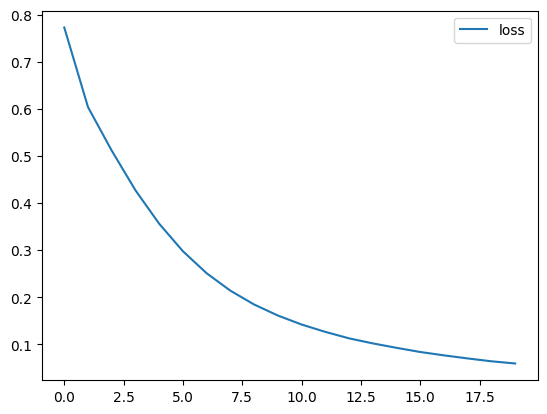

In [188]:
#@title Graphing loss during training

plt.plot(loss_per_epoch, label='loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

In [204]:
def translate_sentences(sentences,#=[(sources, targets)]
                        translation_func, source_tokenizer, encoder,
                        target_tokenizer, decoder):
  translations = {'Tokenized Original': [], 'Reference': [], 'Translation': []}

  for (source, target) in sentences:
    #source, target = s.split(SEPARATOR)
    text = preprocess_text(source)
    reference, translated = translation_func(text, source_tokenizer, encoder,
                                                      target_tokenizer, decoder)

    translations['Tokenized Original'].append(source)
    translations['Reference'].append(target)
    translations['Translation'].append(translated)

  return translations

def translate_with_attention(sentence: str,
                             source_tokenizer, encoder,
                             target_tokenizer, decoder,
                             max_translated_len = 30):

    text = source_tokenizer.texts_to_sequences([sentence])
    text = pad_sequences(text, maxlen=max_encoding_len, padding='post')
    text = tf.convert_to_tensor(text)

    hidden = [tf.zeros([1, hidden_dim]), tf.zeros([1, hidden_dim])]
    encoder_output, decoder_hidden, _  = encoder.predict([text, hidden])

    decoder_input = tf.expand_dims([target_tokenizer.word_index['<sos>']], 0)

    result = []
    for t in range(max_decoding_len):
        logits, decoder_hidden, _, _ = decoder.predict([decoder_input, encoder_output, decoder_hidden])
        logits_index = np.argmax(logits[0])

        current_word = target_tokenizer.index_word[logits_index]
        #print(current_word, logits_index)
        if (current_word == '<eos>'): break

        result.append(current_word)
        decoder_input = tf.expand_dims([logits_index], 0)

    return sentence, ' '.join(result[1:-1])

In [206]:
shorter_translations_w_attention = pd.DataFrame(translate_sentences(samples_test, translate_with_attention,
                                                                    source_tokenizer, encoder,
                                                                    target_tokenizer, decoder))
shorter_translations_w_attention

1/1 [==============================] - 0s 19ms/step


,Tokenized Original,Reference,Translation
0,No pueden culparlos.,You can't blame them.,they can't stand it
1,El hombre mayor vivía en el apartamento de tre...,The old man lived in the three-room apartment.,the older girl lived in three of the u
2,Él me miró fijamente y no dijo nada.,He stared at me and said nothing.,he looked at me and not to nothing
3,Deberías decir la verdad.,You should tell the truth.,you should tell the truth
4,¿Necesitás más dinero?,Do you need more money?,do you need more money
...,...,...,...
95,"¿Puedes limitarte a responder a la pregunta, p...",Could you just please answer the question? We ...,"can you identify yourself to the question , do..."
96,"Cada vez que lo veo, está sonriendo.","Every time I see him, he is smiling.","every time i see him , he would never killed him"
97,Es imposible que él se olvidara de nuestra reu...,It's impossible that he forgot our meeting.,it's impossible for granted that you will go o...
98,Las estrellas no se ven durante el día.,Stars cannot be seen in the daytime.,stars are not for the day


In [194]:
!pip install transformers # If you are using collab, "!" is required to download
!pip install bert-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyli

In [195]:
# import dependencies and load model
from transformers import BertTokenizer, BertForMaskedLM, BertModel
from bert_score import BERTScorer

scorer = BERTScorer(model_type='bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [207]:
candidates = shorter_translations_w_attention["Translation"]
references = shorter_translations_w_attention["Reference"]

In [208]:
def calculate_BERTScores(candidates=candidates, references=references):

  precisions, recalls, f1s = [], [], []

  for i in range(len(references)):
    P, R, F1 = scorer.score([candidates[i]], [references[i]])
    precisions.append(f"{P.mean():.4f}")
    recalls.append(f"{R.mean():.4f}")
    f1s.append(f"{F1.mean():.4f}")

  return precisions, recalls, f1s

In [209]:
ps, rs, fs = calculate_BERTScores()
shorter_translations_w_attention["Precision"] = ps
shorter_translations_w_attention["Recall"] = rs
shorter_translations_w_attention["F1"] = fs

### Loading dataframe

In [210]:
def load_translation_data(data):
  return pd.DataFrame(data)

In [211]:
translations_luong_attn_eval = load_translation_data(shorter_translations_w_attention)
translations_luong_attn_eval.head(10)

,Tokenized Original,Reference,Translation,Precision,Recall,F1
0,No pueden culparlos.,You can't blame them.,they can't stand it,0.5843,0.5573,0.5705
1,El hombre mayor vivía en el apartamento de tre...,The old man lived in the three-room apartment.,the older girl lived in three of the u,0.5165,0.4912,0.5035
2,Él me miró fijamente y no dijo nada.,He stared at me and said nothing.,he looked at me and not to nothing,0.5917,0.6048,0.5982
3,Deberías decir la verdad.,You should tell the truth.,you should tell the truth,0.9207,0.8581,0.8883
4,¿Necesitás más dinero?,Do you need more money?,do you need more money,0.9078,0.8462,0.8759
5,Esperarán.,They'll wait.,take care,0.3490,0.3372,0.3430
6,La Guerra Fría empezó después de la Segunda Gu...,The Cold War began after the Second World War.,the cold war began after world war,0.9008,0.8088,0.8523
7,¿Qué clase de mercaderías vendes en tu negocio?,What kinds of goods do you sell in your shop?,what kind of jewelry are going on your business,0.6190,0.6011,0.6100
8,¿Tienes la boleta?,Do you have a receipt?,do you have your help,0.6357,0.5833,0.6084
9,Creo que es altamente improbable que vuelva a ...,I think it's highly unlikely that I'll ever se...,i think it's highly unlikely that you watch my...,0.5325,0.5693,0.5503


In [212]:
#@title Saving translation history for comparison notebook
SAVED_PKL_PATH = "./bahdanau-attn-translations.pkl"

# Open a file and use dump()
with open(SAVED_PKL_PATH, 'wb') as file:

    # A new file will be created
    pickle.dump(translations_luong_attn_eval, file)